**Data Acquisition**

---

In [ ]:
!pip install emoji
!pip install sastrawi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from transformers import BertTokenizer
from wordcloud import WordCloud
import joblib
# sns.set_palette("Blues")

In [ ]:
df = pd.read_csv('/content/pembatalankenaikanUKT2.csv')

In [ ]:
df.columns

Index(['conversation_id_str', 'created_at', 'favorite_count', 'full_text',
       'id_str', 'image_url', 'in_reply_to_screen_name', 'lang', 'location',
       'quote_count', 'reply_count', 'retweet_count', 'tweet_url',
       'user_id_str', 'username'],
      dtype='object')

**Data Preprocessing**

---



In [ ]:
print(df['favorite_count'].unique())
print()
print(df['reply_count'].unique())

[   0    1    8   19   17   14    2   25   51   37   36   15    4    5
   16   24    6   38  177   20   96  465   30   34   40  158   45 1441
   13    9    7    3  113   52   70   39  190   10 5873  558   65   12
   66   32   21  124  116  255   35   69  682  105   95 1442]

[  0   1   3   4   2  28 132 105   9  10  89   6  45 417   5   7  16 368
  12]


In [ ]:
df.dtypes

conversation_id_str         int64
created_at                 object
favorite_count              int64
full_text                  object
id_str                      int64
image_url                  object
in_reply_to_screen_name    object
lang                       object
location                   object
quote_count                 int64
reply_count                 int64
retweet_count               int64
tweet_url                  object
user_id_str                 int64
username                   object
dtype: object

In [ ]:
df = df[["full_text"]]

In [ ]:
df.head()

,full_text
0,@WagimanDeep212_ Udah kebaca mbib UkT batal na...
1,@detikcom Karena hutang Menggunung Koruptor Me...
2,1. UKT batal naik https://t.co/uw1EcK5ttF
3,@Botsun @nodahitam0 @AndrewsTjan Ini bukan lag...
4,UKT Batal Naik ??? https://t.co/fh89WgyWLJ


In [ ]:
# Lowercase all text
df['full_text'] = df['full_text'].str.lower()
# Remove numbers
df['full_text'] = df['full_text'].apply(lambda x: re.sub(r'\d', '', x))
# Fill missing values with empty string
df['full_text'] = df['full_text'].fillna('')
# Remove mentions using regular expression
df['full_text'] = df['full_text'].apply(lambda x: re.sub(r'@\w+', '', x))
# Remove emojis using regular expression
df['full_text'] = df['full_text'].apply(lambda x: re.sub(r'[\U00010000-\U0010ffff]', '', x))
# Remove URLs
df['full_text'] = df['full_text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))
# Remove "" signs
df['full_text'] = df['full_text'].str.replace('"', '')
# Remove punctuation
df['full_text'] = df['full_text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

df.head()

,full_text
0,udah kebaca mbib ukt batal naik bea masuk dit...
1,karena hutang menggunung koruptor meningkat a...
2,ukt batal naik
3,ini bukan lagi soal kalah menang tpsoal ken...
4,ukt batal naik


### Using NLTK

In [ ]:
# Download NLTK stopwords
nltk.download('stopwords')

# Get Indonesian stopwords from NLTK
nltk_stopwords = set(stopwords.words('indonesian'))

# Initialize Sastrawi stemmer and stopword remover
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()
stopword_factory = StopWordRemoverFactory()
sastrawi_stopwords = set(stopword_factory.get_stop_words())

# Combine NLTK and Sastrawi stopwords
combined_stopwords = nltk_stopwords.union(sastrawi_stopwords)

# Add custom stopwords
additional_stopwords = {'yg', 'lo', 'gw','min','ya','yaa','ga','gak','jd','sih','ni','klo','kl',
                        'wkwk','yak','gk','tuh','tu','tp','si','tau','tahu','kali','kek','deh',
                        'dh','sok','kau','ma','sma','sama','dek','kok','ko','mu','hahaha','aja',
                        'nya','loh','udh','jgn','gua','d','ah','ntar','dah','ku','bgt','tdk','lu',
                        'gue','doang','ny','b','skrg','nih','nah','nnti','jdi','emang','emg','pa',
                        'sdh','bs','haha','wkwkwk','org','ayo','yuk', 'kalo', 'banget'}

optional_stopwords = {
    "permen", "boc", "salur", "bjir", "th", "gt", "u", "yahh", "kagak", "gonjang", "see",
    "unnes", "unri", "ugm", "ui", "thn", "yujiem", "lets", "moga", "ganjing", "buzzerp",
    "buzzermp", "fkg", "fikri", "eh", "newsupdate", "dgn", "jg", "tag ", "news", "um",
    "viral", "tni", "mas", "ta", "ub", "lg", "dn", "neng", "lulu", "dpt", "laku", "byk", "jg"}

combined_stopwords.update(additional_stopwords)
combined_stopwords.update(optional_stopwords)

# Define protected words
protected_words = {'naik'}

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in combined_stopwords or word.lower() in protected_words])

def preprocess_text(text):
    # Tokenize text
    tokens = text.split()
    # Stem tokens
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    # Remove stopwords
    filtered_tokens = [token for token in stemmed_tokens if token.lower() not in combined_stopwords or token.lower() in protected_words]
    return ' '.join(filtered_tokens)

def preprocess_dataframe(df):
    # Convert to lowercase and preprocess text
    df['processed_text'] = df['full_text'].apply(lambda x: preprocess_text(x.lower()))
    return df

# Assuming df is your DataFrame, preprocess the DataFrame
df = preprocess_dataframe(df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def remove_emojis(text):
    demojized_text = emoji.demojize(text)
    no_emoji_text = re.sub(r':[a-z_]+:', '', demojized_text)
    return no_emoji_text

df['processed_text'] = df['processed_text'].apply(remove_emojis)

*Final Data*

---

Data is cleaned from redundant stopwords as well as emojis and other random words.

In [ ]:
df.head()

,full_text,processed_text
0,udah kebaca mbib ukt batal naik bea masuk dit...,udah baca mbib ukt batal naik bea masuk ditert...
1,karena hutang menggunung koruptor meningkat a...,hutang gunung koruptor tingkat apbn tip rakyat...
2,ukt batal naik,ukt batal naik
3,ini bukan lagi soal kalah menang tpsoal ken...,kalah menang tpsoal naik oajak bbm ppn listrik...
4,ukt batal naik,ukt batal naik


**Word Cloud**

---



naik 505
ukt 467
batal 429
nadiem 94
jokowi 76
mahasiswa 72
tapera 59
presiden 51
kuliah 46
uang 45
ptn 44
didik 40
bijak 37
rakyat 35
bikin 33
menteri 32
pahlawan 28
udah 27
alhamdulillah 26
makarim 26


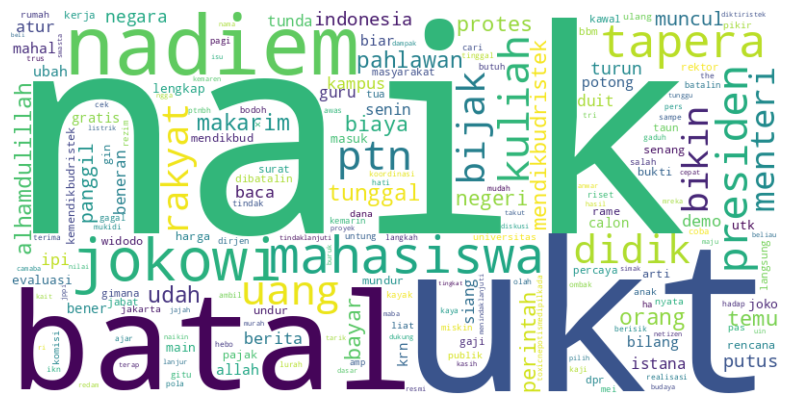

In [ ]:
# Join all comments into a single string
text = ' '.join(comment for comment in df['processed_text'])

# Count the occurrences of each word
word_freq = {}
for word in text.split():
    word_freq[word] = word_freq.get(word, 0) + 1

# Create and generate the word cloud based on frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Print the list of top 20 most common words
top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
for word, freq in top_words:
    print(word, freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

batal naik 1.0
ukt batal 0.636085626911315
naik ukt 0.44036697247706424
ukt 0.22935779816513763
tapera 0.1559633027522936
mahasiswa 0.12844036697247707
rakyat 0.10703363914373089
bijak 0.09174311926605505
udah 0.08256880733944955
alhamdulillah 0.07951070336391437
uang kuliah 0.07951070336391437
nadiem 0.0764525993883792
kuliah tunggal 0.0764525993883792
menteri 0.07339449541284404
ptn 0.07339449541284404
perintah 0.07033639143730887
bikin 0.0672782874617737
protes 0.0672782874617737
tunggal ukt 0.0672782874617737
naik uang 0.0672782874617737
didik 0.06422018348623854
pahlawan 0.06422018348623854
nadiem makarim 0.06422018348623854
presiden 0.06116207951070336
indonesia 0.05504587155963303
putus 0.05504587155963303
mendikbudristek nadiem 0.05504587155963303
turun 0.05198776758409786
negara 0.05198776758409786
orang 0.04892966360856269
temu jokowi 0.04892966360856269
jokowi nadiem 0.04892966360856269
demo 0.045871559633027525
biaya 0.045871559633027525
kampus 0.045871559633027525
berita 0

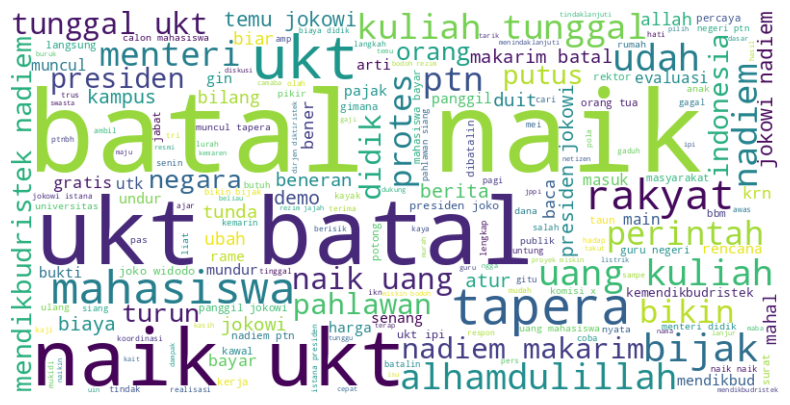

In [ ]:
# Join all comments into a single string
text = ' '.join(comment for comment in df['processed_text'])

# Create and generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Extract word frequencies from the word cloud object
word_freq = wordcloud.words_

# Sort the word frequencies in descending order
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Print the list of most common words
for word, freq in sorted_word_freq:
    print(word, freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Model Development**

---



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report

!git clone https://github.com/indobenchmark/indonlu

fatal: destination path 'indonlu' already exists and is not an empty directory.


#### IndoNLU

*Data used is from the IndoNLU big dataset*

In [ ]:
data_train = pd.read_csv("/content/train_preprocess.tsv", sep='\t')
data_test = pd.read_csv("/content/valid_preprocess.tsv", sep='\t')

data_train

,"warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !",positive
0,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
1,lokasi strategis di jalan sumatera bandung . t...,positive
2,betapa bahagia nya diri ini saat unboxing pake...,positive
3,duh . jadi mahasiswa jangan sombong dong . kas...,negative
4,"makanan beragam , harga makanan di food stall ...",positive
...,...,...
10994,tidak kecewa,positive
10995,enak rasa masakan nya apalagi kepiting yang me...,positive
10996,hormati partai-partai yang telah berkoalisi,neutral
10997,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [ ]:
# Reading the train and test data with specified column names
data_train = pd.read_csv("/content/train_preprocess.tsv", sep='\t', names=['Teks', 'Target'])
data_test = pd.read_csv("/content/valid_preprocess.tsv", sep='\t', names=['Teks', 'Target'])

# Display the first few rows of the train data to verify
data_train.head()

# Display the first few rows of the test data to verify
data_test.head()

,Teks,Target
0,"meski masa kampanye sudah selesai , bukan bera...",neutral
1,tidak enak,negative
2,restoran ini menawarkan makanan sunda . kami m...,positive
3,lokasi di alun alun masakan padang ini cukup t...,positive
4,betapa bejad kader gerindra yang anggota dprd ...,negative


In [ ]:
print(data_train.shape)
print(data_test.shape)

(11000, 2)
(1260, 2)


In [ ]:
data_train['Target'].value_counts()

Target
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

In [ ]:
# data_train.groupby('Target').size().plot(kind='bar')

In [ ]:
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors = vectorizer.fit_transform(data_train['Teks'])
test_vectors = vectorizer.transform(data_test['Teks'])

#### SVC

In [ ]:
classifier_linear = svm.SVC(kernel='rbf')
classifier_linear.fit(train_vectors, data_train['Target'])
prediction_linear = classifier_linear.predict(test_vectors)

In [ ]:
target_names = ['positive', 'negative', 'netral']
print(classification_report(data_test['Target'], prediction_linear, target_names=target_names))

              precision    recall  f1-score   support

    positive       0.81      0.87      0.84       394
    negative       0.88      0.65      0.75       131
      netral       0.92      0.93      0.92       735

    accuracy                           0.88      1260
   macro avg       0.87      0.81      0.84      1260
weighted avg       0.88      0.88      0.88      1260



**Sentiment Prediction on Dataset**

---



In [ ]:
# save and load the trained SVM classifier
joblib.dump(classifier_linear, 'svm_model.pkl')
loaded_model = joblib.load('svm_model.pkl')

df_vectors = vectorizer.transform(df['full_text'])

predictions = loaded_model.predict(df_vectors)

df['sentiments'] = predictions

df.head()

,full_text,processed_text,sentiments
0,udah kebaca mbib ukt batal naik bea masuk dit...,udah baca mbib ukt batal naik bea masuk ditert...,positive
1,karena hutang menggunung koruptor meningkat a...,hutang gunung koruptor tingkat apbn tip rakyat...,negative
2,ukt batal naik,ukt batal naik,neutral
3,ini bukan lagi soal kalah menang tpsoal ken...,kalah menang tpsoal naik oajak bbm ppn listrik...,negative
4,ukt batal naik,ukt batal naik,neutral


In [ ]:
print(df['sentiments'])

0      positive
1      negative
2       neutral
3      negative
4       neutral
         ...   
635     neutral
636     neutral
637    negative
638    negative
639    negative
Name: sentiments, Length: 640, dtype: object


In [ ]:
count_data = pd.DataFrame(
    columns = ['count'],
    index = ['positive', 'negative', 'neutral']
)

neg_count = df['sentiments'].value_counts().get('negative', 0)
pos_count = df['sentiments'].value_counts().get('positive', 0)
neut_count = df['sentiments'].value_counts().get('neutral', 0)

count_data.loc['positive', 'count'] = pos_count
count_data.loc['negative', 'count'] = neg_count
count_data.loc['neutral', 'count'] = neut_count

count_data

,count
positive,65
negative,371
neutral,204


<Axes: >

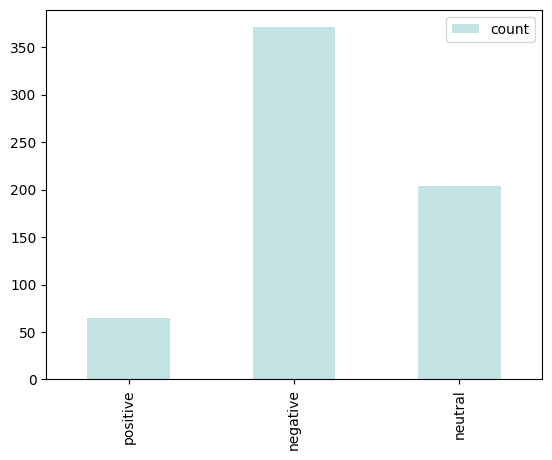

In [ ]:
count_data.plot(kind = 'bar')

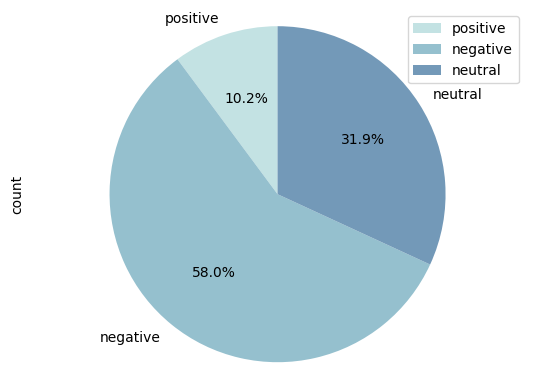

In [ ]:
sns.set_palette("ch:start=.2,rot=-.3")

count_data.plot(kind='pie', y='count', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

In [ ]:
# Split DataFrame based on sentiment values
positive_df = df[df['sentiments'] == 'positive']
neutral_df = df[df['sentiments'] == 'neutral']
negative_df = df[df['sentiments'] == 'negative']

In [ ]:
# Checking if the splitting was correct
columns = [positive_df, neutral_df, negative_df]

for column in columns:
  print(column['sentiments'].value_counts())

sentiments
positive    65
Name: count, dtype: int64
sentiments
neutral    204
Name: count, dtype: int64
sentiments
negative    371
Name: count, dtype: int64


Negative Sentiments:
batal naik 1.0
ukt 0.84
alhamdulillah 0.84
ukt batal 0.76
naik 0.6
tapera 0.32
jokowi 0.28
mahasiswa 0.2
udah 0.16
gagal 0.16
nadiem 0.16
untung 0.16
biaya 0.16
masuk 0.12
kuat 0.12
senang 0.12
berkat 0.12
kawal 0.12
ipi 0.12
percaya 0.12
puji tuhan 0.12
protes 0.08
berisik 0.08
swasta 0.08
orang 0.08
tua 0.08
uang 0.08
mantap 0.08
pas 0.08
presiden 0.08
bagus 0.08
benah 0.08
guru 0.08
aspirasi 0.08
respons 0.08
kuliah 0.08
pts 0.08
kampus 0.08
murah 0.08
beneran 0.08
realisasi 0.08
turun 0.08
allah 0.08
ttp 0.08
bikin 0.08
atur 0.08
gitu 0.08
demo 0.08
ps 0.08
konoha 0.08
baca 0.04
mbib 0.04
bea 0.04
ditertibin 0.04
lawan 0.04
ide 0.04
box 0.04
gelombang 0.04
pertalite 0.04
rame 0.04
nominal 0.04
seram 0.04
selamat 0.04
juang 0.04
ptn 0.04
sehat 0.04
semangat 0.04
kerja 0.04
keras 0.04
thx 0.04
taperan 0.04
engga 0.04
sebenernya 0.04
harga 0.04
kedok 0.04
mendaptkan 0.04
korupsi 0.04
kongkalikong 0.04
kirakira 0.04
ngurus 0.04
revisi 0.04
dilibatin 0.04
colong 0.0

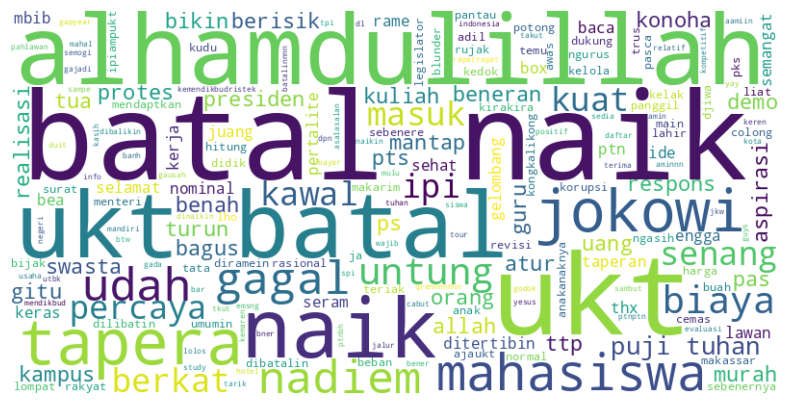

Negative Sentiments:
batal naik 1.0
ukt batal 0.538961038961039
naik ukt 0.45454545454545453
ptn 0.15584415584415584
mahasiswa 0.14935064935064934
uang kuliah 0.14935064935064934
kuliah tunggal 0.14285714285714285
tunggal ukt 0.13636363636363635
naik uang 0.13636363636363635
ukt 0.12337662337662338
nadiem makarim 0.12337662337662338
mendikbudristek nadiem 0.11688311688311688
makarim batal 0.09090909090909091
jokowi 0.08441558441558442
didik 0.08441558441558442
presiden jokowi 0.08441558441558442
nadiem 0.07792207792207792
muncul 0.07792207792207792
indonesia 0.07142857142857142
tapera 0.07142857142857142
putus 0.07142857142857142
bijak 0.06493506493506493
perintah 0.06493506493506493
senin 0.06493506493506493
presiden joko 0.06493506493506493
joko widodo 0.06493506493506493
menteri 0.05844155844155844
evaluasi 0.05844155844155844
guru negeri 0.05844155844155844
panggil 0.05194805194805195
berita 0.05194805194805195
surat 0.05194805194805195
komisi x 0.05194805194805195
temu jokowi 0.05

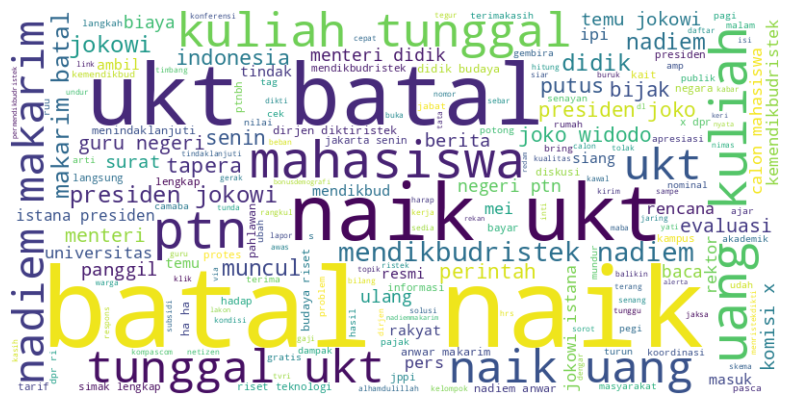

Negative Sentiments:
batal naik 1.0
ukt batal 0.7094594594594594
naik ukt 0.39864864864864863
ukt naik 0.2905405405405405
tapera 0.2702702702702703
rakyat 0.19594594594594594
ukt 0.18243243243243243
mahasiswa 0.18243243243243243
nadiem 0.16216216216216217
udah 0.13513513513513514
bikin 0.12837837837837837
bijak 0.12837837837837837
protes 0.10810810810810811
presiden 0.10810810810810811
pahlawan 0.10810810810810811
uang 0.10135135135135136
menteri 0.10135135135135136
orang 0.10135135135135136
didik 0.0945945945945946
naik 0.08783783783783784
duit 0.08783783783783784
demo 0.08783783783783784
perintah 0.08783783783783784
negara 0.08783783783783784
atur 0.08783783783783784
turun 0.08108108108108109
tunda 0.08108108108108109
mahal 0.08108108108108109
ptn 0.08108108108108109
biar 0.08108108108108109
kuliah 0.07432432432432433
bilang 0.07432432432432433
beneran 0.07432432432432433
krn 0.07432432432432433
allah 0.07432432432432433
biaya 0.06756756756756757
bener 0.06756756756756757
bayar 0.067

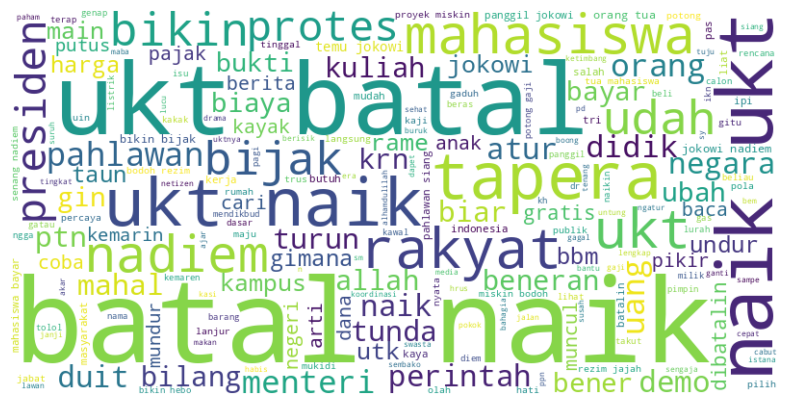

In [ ]:
for column in columns:
  # Join all comments into a single string
  text = ' '.join(comment for comment in column['processed_text'])

  # Create and generate the word cloud
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

  # Extract word frequencies from the word cloud object
  word_freq = wordcloud.words_

  # Sort the word frequencies in descending order
  sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

  # Print the list of most common words
  print(f"{sentiment.capitalize()} Sentiments:")
  for word, freq in sorted_word_freq:
   print(word, freq)

  # Display the word cloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

Positive Sentiments:


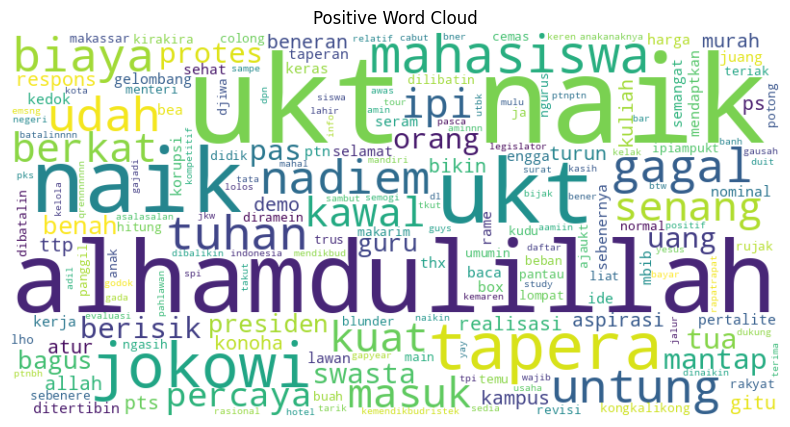

Neutral Sentiments:


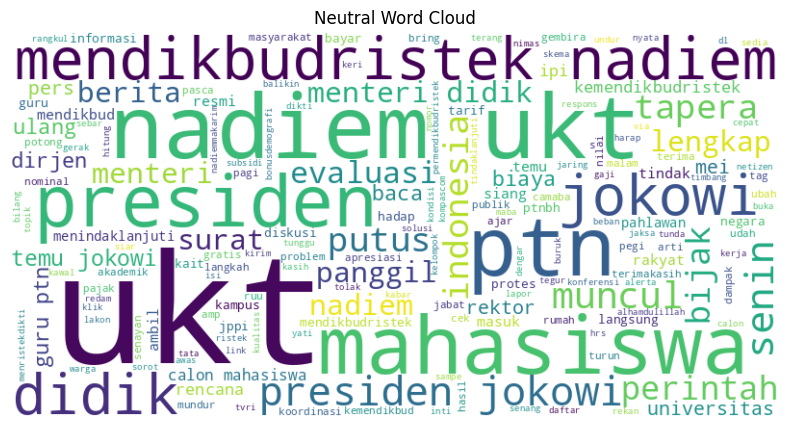

Negative Sentiments:


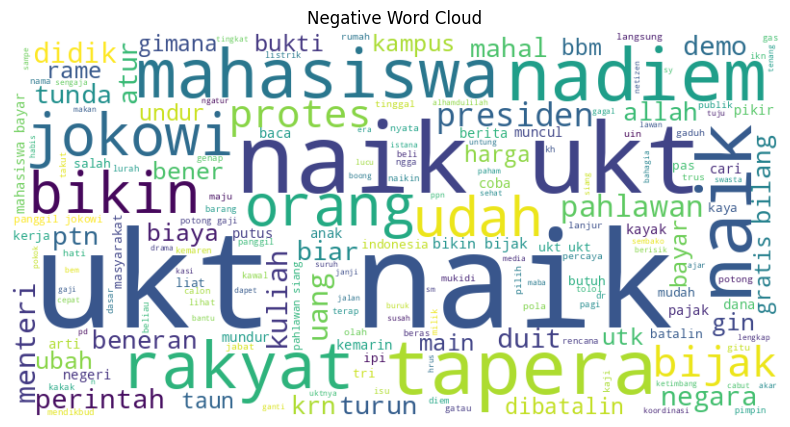

In [ ]:
# Define frequency thresholds for each sentiment type
frequency_thresholds = {
    'positive': 0.04,
    'neutral': 0.012987012987012988,
    'negative': 0.02027027027027027
}

def filter_low_freq_words(text, min_freq):
    # Generate word cloud and extract word frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    word_freq = wordcloud.words_

    # Filter out words with frequencies below min_freq
    filtered_words = {word: freq for word, freq in word_freq.items() if freq >= min_freq}

    # Generate a new text with only the filtered words
    filtered_text = ' '.join(word for word in text.split() if word in filtered_words)
    return filtered_text

# Process each sentiment category
filtered_texts = []
for sentiment, threshold in frequency_thresholds.items():
    sentiment_df = df[df['sentiments'] == sentiment]
    text = ' '.join(sentiment_df['processed_text'])

    # Filter low-frequency words
    filtered_text = filter_low_freq_words(text, threshold)
    filtered_texts.append({'sentiments': sentiment, 'filtered_text': filtered_text})

# Create a new DataFrame with the filtered texts
filtered_df = pd.DataFrame(filtered_texts)

# Display the word clouds
for sentiment, threshold in frequency_thresholds.items():
    sentiment_text = filtered_df[filtered_df['sentiments'] == sentiment]['filtered_text'].values[0]

    # Create and generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sentiment_text)

    # Extract word frequencies from the word cloud object
    word_freq = wordcloud.words_

    # Sort the word frequencies in descending order
    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    # Print the list of most common words
    print(f"{sentiment.capitalize()} Sentiments:")
    #for word, freq in sorted_word_freq:
    #   print(word, freq)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment.capitalize()} Word Cloud")
    plt.show()

In [ ]:
# df.to_csv(r"/content/df(sentiment).csv", index=False)